sign-language-mnist : https://www.kaggle.com/datasets/datamunge/sign-language-mnist

chatbot dataset :  https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# code to connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
sign_train_df = pd.read_csv("/content/drive/MyDrive/AAI-Capstone-Data/sign_mnist_train.csv")
sign_test_df = pd.read_csv("/content/drive/MyDrive/AAI-Capstone-Data/sign_mnist_test.csv")


In [6]:
sign_train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [8]:
sign_train_df.shape

(27455, 785)

In [7]:
sign_test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [9]:
sign_test_df.shape

(7172, 785)

# Quick EDA

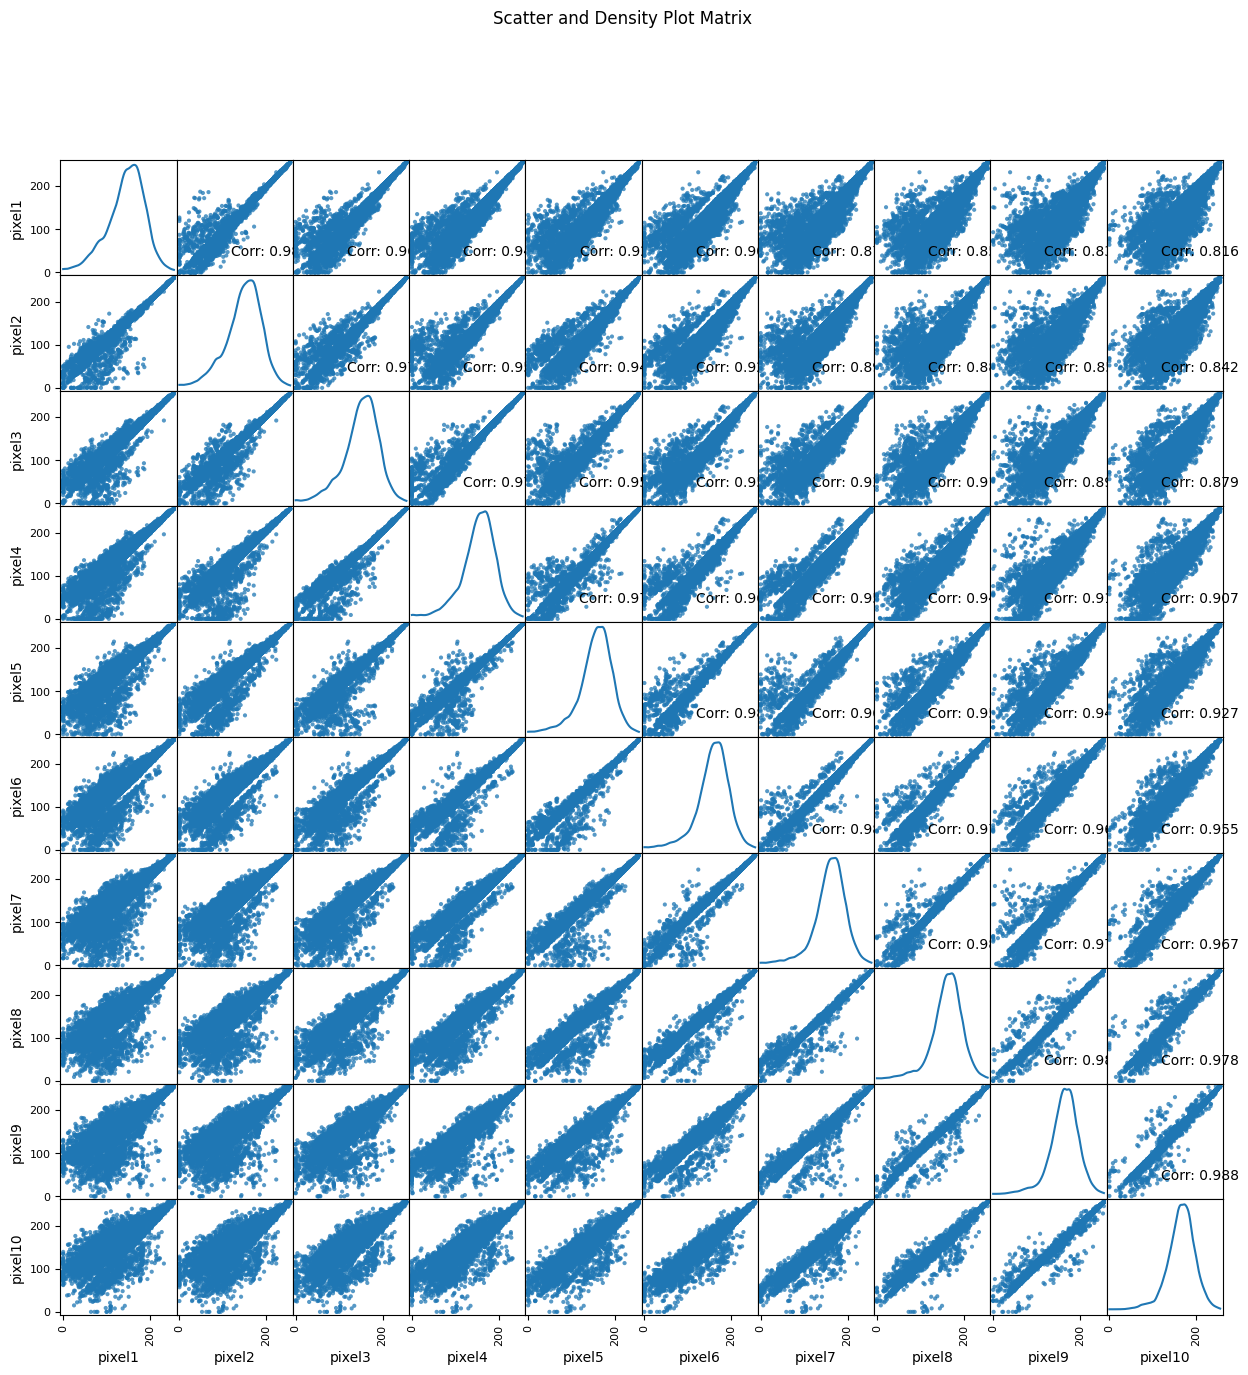

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scatter_density(df, plot_size=15, text_size=10):
    """
    Generates a scatter and density plot matrix for numerical columns in the dataframe.

    Parameters:
    - df: Input DataFrame containing the dataset.
    - plot_size: Size of the plot (default is 15).
    - text_size: Size of the text annotations (default is 10).
    """
    # Select only numerical columns and remove columns with NaN values
    numeric_df = df.select_dtypes(include=[np.number]).dropna(axis=1)

    # Keep columns with more than one unique value to avoid singularity
    numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]

    # Exclude the target/label column
    label_col = 'label'
    if label_col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[label_col])

    # Limit the number of columns to avoid issues with kernel density plots
    if numeric_df.shape[1] > 10:
        numeric_df = numeric_df.iloc[:, :10]

    # Create the scatter matrix plot
    ax = pd.plotting.scatter_matrix(numeric_df, alpha=0.75, figsize=(plot_size, plot_size), diagonal='kde')

    # Calculate the correlation coefficients
    correlations = numeric_df.corr().values

    # Annotate the plots with correlation coefficients
    for i in range(len(correlations)):
        for j in range(i+1, len(correlations)):
            ax[i, j].annotate(f'Corr: {correlations[i, j]:.3f}', (0.8, 0.2), xycoords='axes fraction',
                              ha='center', va='center', size=text_size)

    # Set the title of the plot
    plt.suptitle('Scatter and Density Plot Matrix')
    plt.show()

# Example usage with sign_train_df
plot_scatter_density(sign_train_df, plot_size=15, text_size=10)


### Data Preparation

In [13]:
# Normalize and reshape training images to (27455, 28, 28, 1)
training_images = sign_train_df.loc[:, "pixel1":"pixel784"].values.reshape(27455, 28, 28, 1) / 255.0

# Extract training labels
training_labels = sign_train_df.loc[:, "label"].values

# Normalize and reshape test images to (7172, 28, 28, 1)
test_images = sign_test_df.loc[:, "pixel1":"pixel784"].values.reshape(7172, 28, 28, 1) / 255.0

# Extract test labels
test_labels = sign_test_df.loc[:, "label"].values


# Model Training

In [17]:
import tensorflow as tf  # Import TensorFlow

# Define the model
model = tf.keras.models.Sequential([
  # First convolutional layer with 32 filters, 3x3 kernel, ReLU activation, and input shape
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),  # First max-pooling layer with 2x2 pool size

  # Second convolutional layer with 64 filters and 3x3 kernel
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),  # Second max-pooling layer with 2x2 pool size

  # Third convolutional layer with 128 filters and 3x3 kernel
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),  # Third max-pooling layer with 2x2 pool size

  tf.keras.layers.Flatten(),  # Flatten the output to feed into the dense layers
  tf.keras.layers.Dense(256, activation='relu'),  # Dense layer with 256 neurons and ReLU activation
  tf.keras.layers.Dropout(0.2),  # Dropout layer with 20% dropout rate
  tf.keras.layers.Dense(25, activation='softmax')  # Output layer with 25 neurons and softmax activation
])

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()  # Print the model summary

# Train the model with training images and labels, validate with test images and labels, for 3 epochs and batch size of 64
history = model.fit(training_images, training_labels, validation_data=(test_images, test_labels), epochs=3, batch_size=64)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 1, 1, 128)        

# save the trained model

In [18]:
model.save('/content/drive/MyDrive/AAI-Capstone-Data/sign_language_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## plot the training accuracy, training loss, validation accuracy, and validation loss from the history object

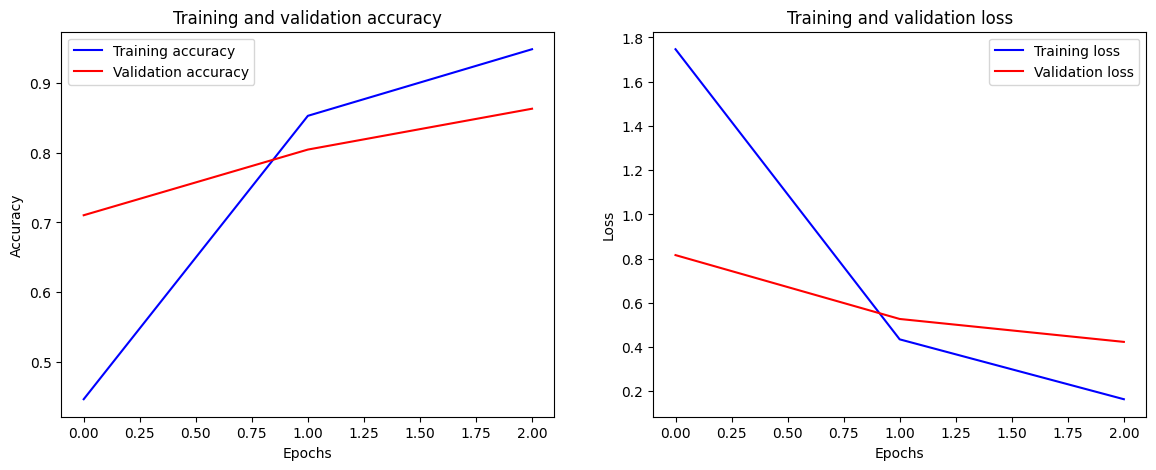

In [19]:
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Plot the training and validation accuracy and loss
def plot_training_history(history):
    # Extract the accuracy and loss values for both training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))  # Number of epochs

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)


# Model Evaluation

In [20]:

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/AAI-Capstone-Data/sign_language_model.h5')

# Evaluate the loaded model on the test dataset
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

# Print the test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


225/225 - 2s - loss: 0.4236 - accuracy: 0.8631 - 2s/epoch - 10ms/step
Test Accuracy: 0.8631
Test Loss: 0.4236
